In [94]:
import pandas as pd
import json
import re
import json
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch.nn as nn


To obtain data, I used this [Lego Star Wars Website](https://brickfact.com/sets/lego-star-wars-tie-fighter-pilot-helmet-75274?timeRange=ALL) and pulled the relevant HTML for the prices of the lego set over time. I then need to fill in values and convert into a Pandas dataframe.

In [95]:
with open('LEGO Star Wars TIE Fighter Pilot Helmet price over time.txt', 'r', encoding='utf-8') as file:
    content = file.read()

content

'[{date:"2020-03-30",value:c},{date:"2020-04-06",value:c},{date:"2020-04-13",value:c},{date:"2020-04-20",value:c},{date:"2020-04-27",value:c},{date:"2020-05-04",value:c},{date:"2020-05-11",value:c},{date:"2020-05-18",value:c},{date:"2020-05-25",value:c},{date:"2020-06-01",value:c},{date:"2020-06-08",value:c},{date:"2020-06-15",value:c},{date:"2020-06-22",value:c},{date:"2020-06-29",value:65.14267799999999},{date:"2020-07-06",value:a},{date:"2020-07-13",value:a},{date:"2020-07-20",value:a},{date:"2020-07-27",value:a},{date:"2020-08-03",value:a},{date:"2020-08-10",value:a},{date:"2020-08-17",value:a},{date:"2020-08-24",value:a},{date:"2020-08-31",value:a},{date:"2020-09-07",value:a},{date:"2020-09-14",value:a},{date:"2020-09-21",value:64.35755999999999},{date:"2020-09-28",value:64.512372},{date:"2020-10-05",value:a},{date:"2020-10-12",value:a},{date:"2020-10-19",value:a},{date:"2020-10-26",value:a},{date:"2020-11-02",value:a},{date:"2020-11-09",value:a},{date:"2020-11-16",value:a},{date:

In [96]:
def convert_to_dict(data_str):

    replacements = {
        ':c': ':66.48',
        ':a': ':64.81',
        ':A': ':85.22',
        ':k': ':78.15',
        ':B': ':73.87',
        ':P': ':343.20',
        ':z': ':63.42'
    }

    # Swap out placeholders with their corresponding values
    for key, value in replacements.items():
        data_str = data_str.replace(key, value)
    
    data_str = data_str.replace("'", '"')
    
    # Ensure keys are properly quoted
    data_str = re.sub(r'(?<!":)(\w+):', r'"\1":', data_str)
    
    print("Debug: Data string before JSON conversion:\n", data_str)
    
    # Try converting the string to a dictionary
    try:
        data_dict = json.loads(data_str)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")
        return None
    
    return data_dict

data_dict = convert_to_dict(content)

print(data_dict)


Debug: Data string before JSON conversion:
 [{"date":"2020-03-30","value":66.48},{"date":"2020-04-06","value":66.48},{"date":"2020-04-13","value":66.48},{"date":"2020-04-20","value":66.48},{"date":"2020-04-27","value":66.48},{"date":"2020-05-04","value":66.48},{"date":"2020-05-11","value":66.48},{"date":"2020-05-18","value":66.48},{"date":"2020-05-25","value":66.48},{"date":"2020-06-01","value":66.48},{"date":"2020-06-08","value":66.48},{"date":"2020-06-15","value":66.48},{"date":"2020-06-22","value":66.48},{"date":"2020-06-29","value":65.14267799999999},{"date":"2020-07-06","value":64.81},{"date":"2020-07-13","value":64.81},{"date":"2020-07-20","value":64.81},{"date":"2020-07-27","value":64.81},{"date":"2020-08-03","value":64.81},{"date":"2020-08-10","value":64.81},{"date":"2020-08-17","value":64.81},{"date":"2020-08-24","value":64.81},{"date":"2020-08-31","value":64.81},{"date":"2020-09-07","value":64.81},{"date":"2020-09-14","value":64.81},{"date":"2020-09-21","value":64.35755999999

In [97]:
df = pd.DataFrame(data_dict)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df

,date,value
0,2020-03-30,66.480000
1,2020-04-06,66.480000
2,2020-04-13,66.480000
3,2020-04-20,66.480000
4,2020-04-27,66.480000
...,...,...
226,2024-07-29,324.209502
227,2024-08-05,324.817692
228,2024-08-12,327.195162
229,2024-08-19,332.259726


Now that we have clean data to work with, let's look at the general trend. 

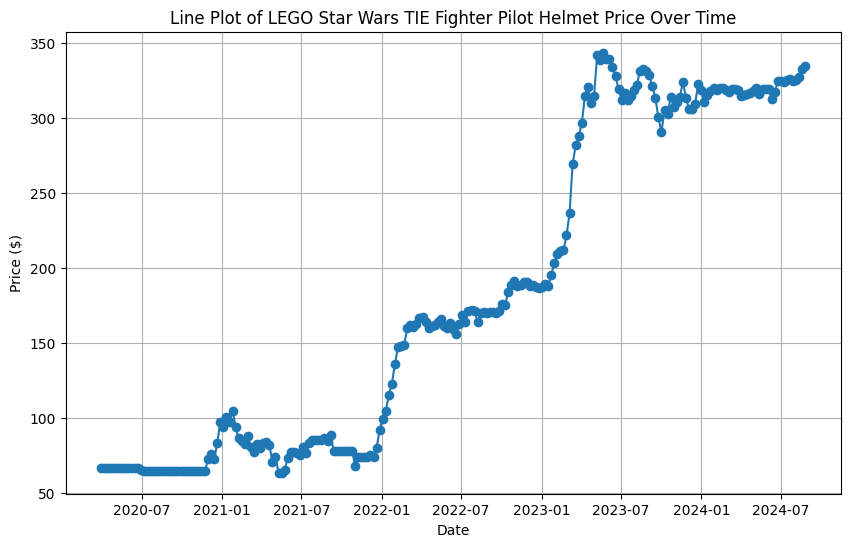

In [98]:
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['value'], marker='o')

plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title('Line Plot of LEGO Star Wars TIE Fighter Pilot Helmet Price Over Time')
plt.grid(True)

We see a general upward trend with clear spikes around the beginning of 2022 and 2023 and a plateau in price over the last year. We can expect our model to either predict similar values or increased values relative to the most recent price of the lego set. Now, we can prepare our data for an RNN model by normalizing values, creating input features and target labels using a sliding window, and converting data into tensors

# Data Preprocessing

In [105]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
df['value'] = scaler.fit_transform(df['value'].values.reshape(-1, 1))

# Convert df to sequences
def create_sequences(df, seq_length):
    xs, ys = [], []
    for i in range(len(df) - seq_length):
        x = df[i:i+seq_length]
        y = df[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 1
x_data, y_data = create_sequences(df['value'].values, seq_length)

x_data = torch.tensor(x_data, dtype=torch.float32)
y_data = torch.tensor(y_data, dtype=torch.float32)


In [76]:
x_data.shape

torch.Size([230, 1])

# RNN Model

In [82]:
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(RNNModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.rnn = nn.RNN(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        # Initialize hidden state as 2D (num_layers, hidden_size) for unbatched input
        hidden_cell = torch.zeros(1, self.hidden_layer_size)
        
        # Forward pass through the RNN
        rnn_out, hidden_cell = self.rnn(input_seq, hidden_cell)
        
        # If the output is 2D, directly pass it through the linear layer
        predictions = self.linear(rnn_out[-1])
        return predictions

# Re-initialize the model
model = RNNModel(input_size=1, hidden_layer_size=100, output_size=1)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 150
for epoch in range(epochs):
    for seq, labels in zip(x_data, y_data):
        optimizer.zero_grad()

        # Forward pass with unbatched data
        y_pred = model(seq.unsqueeze(0))

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if epoch % 25 == 1:
        print(f'Epoch {epoch} loss: {single_loss.item()}')

print(f'Epoch {epoch} loss: {single_loss.item()}')


c:\Users\Tarun Chinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 loss: 0.00039122169255279005
Epoch 26 loss: 8.990542846731842e-05
Epoch 51 loss: 9.946884529199451e-05
Epoch 76 loss: 0.00013168854638934135
Epoch 101 loss: 0.000190929597010836
Epoch 126 loss: 0.00030237523606047034
Epoch 149 loss: 0.00031279915128834546


We reached our minimum mse loss around Epoch 51. The reason our loss increased afterwards is because the RNN architecture has the exploding/vanishing gradient problem (in our case, the gradient is exploding). The same weights and biases are used at each time step in a sequence so small changes in those values will explode over time, making it hard for gradient descent. For example, a weight of 2 over 50 time steps has an output of 2^50 if everything else is controlled. If the weight was 1.99, the output would be 1.99^50, and the difference between the outputs of the two weights is 2 * 10^14 despite the weights being 0.01 apart from each other. To avoid this problem, we can implement an LSTM model that has gating mechanisms to help prevent the gradient from exploding or vanishing.

# Inference

In [106]:
# Model evaluation
model.eval()
predicted_values = []

with torch.no_grad():
    for seq in x_data[-5:]:  # Last 5 sequences for prediction
        model.hidden_cell = torch.zeros(1, 1, model.hidden_layer_size)
        y_pred = model(seq.unsqueeze(0))
        predicted_values.append(y_pred.item())

predicted_values = np.array(predicted_values).reshape(-1, 1)

# Inverse transform to the original scale
predicted_values_original_scale = scaler.inverse_transform(predicted_values)

for i, val in enumerate(predicted_values_original_scale):
    print(f'Predicted value {i+1}: {val[0]}')


Predicted value 1: 327.4627402085066
Predicted value 2: 326.2057642364502
Predicted value 3: 326.6968529444933
Predicted value 4: 328.6070268434286
Predicted value 5: 332.6253543394804


# Next Five Prices

In [107]:
# Start with the last sequence from training data
last_sequence = x_data[-1].clone()

model.eval()
rolling_predictions = []

with torch.no_grad():
    for _ in range(5):  # Predict 5 future values
        # Predict the next value
        model.hidden_cell = torch.zeros(1, 1, model.hidden_layer_size)
        y_pred = model(last_sequence.unsqueeze(0))
        
        rolling_predictions.append(y_pred.item())

        # Update the last_sequence to include the new prediction
        new_value = torch.tensor([y_pred.item()])
        last_sequence = torch.cat((last_sequence[1:], new_value))  # Shift the sequence and add the new prediction

rolling_predictions = np.array(rolling_predictions).reshape(-1, 1)

# Inverse transform to the original scale
rolling_predictions_original_scale = scaler.inverse_transform(rolling_predictions)

for i, val in enumerate(rolling_predictions_original_scale):
    print(f'Predicted future value {i+1}: {val[0]}')


Predicted future value 1: 332.6253543394804
Predicted future value 2: 332.9127600932121
Predicted future value 3: 333.1384139245748
Predicted future value 4: 333.31544833123684
Predicted future value 5: 333.4542275637388


TODO: chart actuals and next predicted 5-10 prices, stop loss for training to get optimal training time, implement batches, create LSTM